In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip -uq "/content/drive/My Drive/FruitsDB" -d "/content"

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd

import glob

In [0]:
def showImg(img, name):
    plt.axis("off")
    plt.title(name)
    plt.imshow(img)
    plt.show()

def _hog(img, B):
  gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
  gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
  mag,ang = cv2.cartToPolar(gx, gy)
  bins = np.int32((ang*B)/(2*np.pi))
  bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
  mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
  hists = [np.bincount(b.ravel(), m.ravel(), B) for b,m in zip(bin_cells, mag_cells)]
  hist = np.hstack(hists)
  return hist

def hog(img, B):
  r = img[:, :, 0]
  g = img[:, :, 1]
  b = img[:, :, 2]
  r = _hog(r, B)
  g = _hog(g, B)
  b = _hog(b, B)
  hist = np.concatenate((r,g,b))
  return hist

def load_data(fruit, tipo, B, clase, testing):
    label=[]
    arr = []
    strr = "FruitsDB/"+fruit+"/" + tipo + "/*"
    for file_ in glob.glob(strr):
      img = cv2.imread(file_)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      h = hog(img, B)
      if(testing):
        arr.append(h)
      else:
        arr.append(img)
      label.append(clase)
   
    return arr,label

def whole_train_data(tipo, B):
  apples_data, apples_label = load_data('Apples', tipo, B, 0, 1)
  mangoes_data, mangoes_label = load_data('Mangoes', tipo, B, 1, 1)
  oranges_data, oranges_label = load_data('Oranges', tipo, B, 2, 1)
  data =np.concatenate((apples_data,mangoes_data,oranges_data))
  labels =np.concatenate((apples_label, mangoes_label, oranges_label))
  return data, labels

In [0]:
data_train, labels_train = whole_train_data('Train', 16)
data_test, labels_test = whole_train_data('Test', 16)

In [0]:
data_test = np.vstack(data_test)
data_train = np.vstack(data_train)
labels_train = np.vstack(labels_train)
labels_test = np.vstack(labels_test)

data_train = np.float32(data_train)
data_test = np.float32(data_test)

In [55]:
print(data_train.shape)
print(labels_train.shape)
print(data_test.shape)
print(labels_test.shape)

(220, 192)
(220, 1)
(66, 192)
(66, 1)


In [0]:
def train_model(data_train, labels_train):
  svm = cv2.ml.SVM_create()
  svm.setKernel(cv2.ml.SVM_LINEAR)
  svm.setType(cv2.ml.SVM_C_SVC)
  svm.setC(2.67)
  svm.setGamma(5.383)

  svm.train(data_train, cv2.ml.ROW_SAMPLE, labels_train)
  return svm

In [0]:
def get_precission(svm, test_target, test):
  result = svm.predict(test)[1]   
  mask = (result==test_target)
  correct = np.count_nonzero(mask)
  return (correct*100.0/result.size)  

In [0]:
svm = train_model(data_train, labels_train)

In [67]:
print("Precision del modelo es {}%".format(get_precission(svm, labels_test, data_test)))

Precision del modelo es 93.93939393939394%


**Trying our model**

In [0]:
classes = ["Apple", "Mango", "Orange"]

In [0]:
apples_data, apples_label = load_data('Apples', 'Test', 0, 0, 0)
mangoes_data, mangoes_label = load_data('Mangoes', 'Test', 0, 1, 0)
oranges_data, oranges_label = load_data('Oranges', 'Test', 0, 2, 0)
data =np.concatenate((apples_data,mangoes_data,oranges_data))

In [0]:
def try_predictor(data, data_test,x_):
  img = data[x_]
  result = int(svm.predict(data_test[x_].reshape(1,192))[1][0][0])
  result = classes[result]
  showImg(img, result)

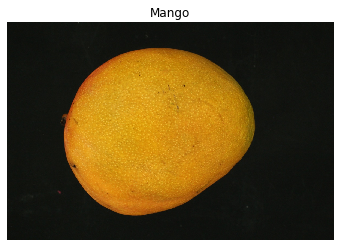

In [140]:
from random import seed
from random import randint  
x_ = randint(0, data.shape[0])
try_predictor(data, data_test, x_)